In [25]:
# Set up
import pandas as pd 
import numpy as np

all_weeks = []

for week in range(1, 18):
    try:
        file_path = f'../data/train/input_2023_w{week:02d}.csv'
        weekly_df = pd.read_csv(file_path)
        weekly_df['week'] = week  # Add week column to track which week the data is from
        all_weeks.append(weekly_df)
        print(f"Loaded week {week:02d}: {len(weekly_df):,} rows")
    except FileNotFoundError:
        print(f"Week {week:02d} file not found, skipping...")

input_df = pd.concat(all_weeks, ignore_index=True)

# for week in range(1, 18):
#     input_df = pd.read_csv(f'../data/train/input_2023_w{week:02d}.csv')
# input_df = pd.read_csv('../data/train/input_2023_w01.csv')

for week in range(1, 18):
    try:
        file_path = f'../data/train/output_2023_w{week:02d}.csv'
        weekly_df = pd.read_csv(file_path)
        weekly_df['week'] = week  # Add week column to track which week the data is from
        all_weeks.append(weekly_df)
        print(f"Loaded week {week:02d}: {len(weekly_df):,} rows")
    except FileNotFoundError:
        print(f"Week {week:02d} file not found, skipping...")

output_df = pd.concat(all_weeks, ignore_index=True)

# output_df = pd.read_csv('../data/train/output_2023_w01.csv')
# print(output_df.head())

supplemental_df = pd.read_csv('../data/supplementary_data.csv')

# Sort by game_id and play_id to ensure proper order
supplemental_df = supplemental_df.sort_values(['game_id', 'play_id'])

# Get the previous play's expected_points_added within each game
supplemental_df['prev_expected_points_added'] = supplemental_df.groupby('game_id')['expected_points_added'].shift(1)

# Calculate the change in EPA from the last play
supplemental_df['epa_change_from_last_play'] = supplemental_df['expected_points_added'] - supplemental_df['prev_expected_points_added']

supplemental_df['coverage_shell'] = supplemental_df['team_coverage_type'].str.replace('_MAN', '').str.replace('_ZONE', '')

# Merge input with supplemental data on game_id and play_id
df_final = pd.merge(supplemental_df, input_df, on=['game_id', 'play_id'], how='left')
print(df_final.shape)
print(input_df.shape)

Loaded week 01: 285,714 rows
Loaded week 02: 288,586 rows
Loaded week 03: 297,757 rows
Loaded week 04: 272,475 rows
Loaded week 05: 254,779 rows
Loaded week 06: 270,676 rows
Loaded week 07: 233,597 rows
Loaded week 08: 281,011 rows
Loaded week 09: 252,796 rows
Loaded week 10: 260,372 rows
Loaded week 11: 243,413 rows
Loaded week 12: 294,940 rows
Loaded week 13: 233,755 rows
Loaded week 14: 279,972 rows
Loaded week 15: 281,820 rows
Loaded week 16: 316,417 rows
Loaded week 17: 277,582 rows
Loaded week 01: 32,088 rows
Loaded week 02: 32,180 rows
Loaded week 03: 36,080 rows
Loaded week 04: 30,147 rows
Loaded week 05: 29,319 rows
Loaded week 06: 31,162 rows
Loaded week 07: 27,443 rows
Loaded week 08: 33,017 rows
Loaded week 09: 28,291 rows
Loaded week 10: 29,008 rows
Loaded week 11: 27,623 rows
Loaded week 12: 32,156 rows
Loaded week 13: 29,568 rows
Loaded week 14: 32,873 rows
Loaded week 15: 32,715 rows
Loaded week 16: 36,508 rows
Loaded week 17: 33,076 rows


/var/folders/7d/j6bnzr6j1s9dc0n2tggc7syr0000gp/T/ipykernel_90840/404915120.py:38: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  supplemental_df = pd.read_csv('../data/supplementary_data.csv')


(4630313, 66)
(4625662, 24)


Analyzing snap frames across all plays...

SNAP FRAME ANALYSIS
Total plays analyzed: 817

Average snap frame: 11.8
Median snap frame: 10.0
Most common snap frame: 10.0

Snap frame distribution:
1.0       1
3.0       1
4.0       4
5.0      10
6.0      26
7.0      45
8.0      77
9.0     121
10.0    125
11.0    107
12.0     82
13.0     49
14.0     34
15.0     31
16.0     19
Name: snap_frame, dtype: int64


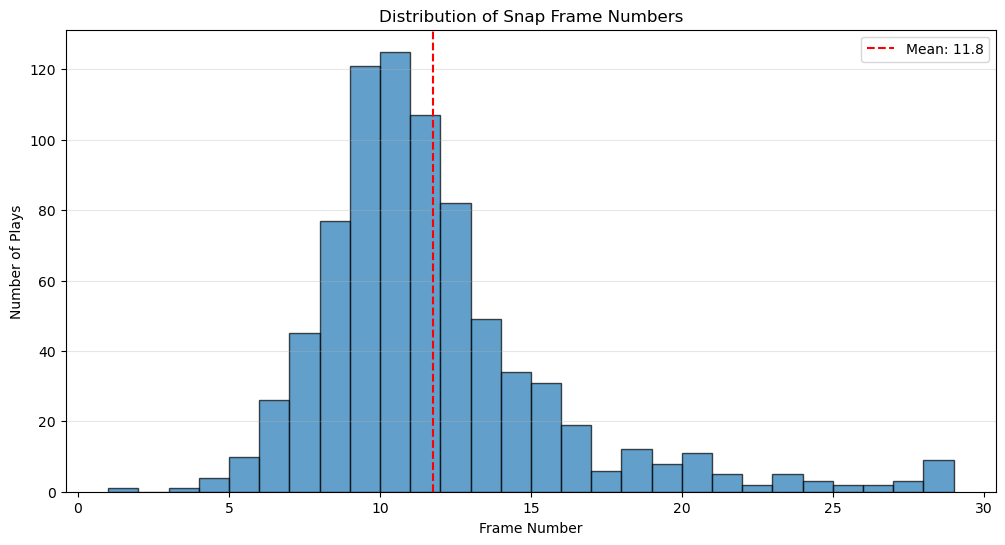

In [15]:
def find_snap_frame(df):
    """
    Find the frame when the ball is snapped by detecting when players cross the line of scrimmage
    """
    snap_frames = []
    
    for (game_id, play_id), play_group in df.groupby(['game_id', 'play_id']):
        # Get the absolute yardline (line of scrimmage)
        los = play_group['absolute_yardline_number'].iloc[0]
        
        # Get play direction
        play_direction = play_group['play_direction'].iloc[0]
        
        # Filter to offensive players (not defense)
        offense = play_group[play_group['player_side'] == 'Offense']
        
        if len(offense) == 0:
            continue
        
        # Track when players cross the LOS based on play direction
        for (player_id), player_group in offense.groupby('nfl_id'):
            player_frames = player_group.sort_values('frame_id')
            
            # Check when x-coordinate crosses the LOS
            if play_direction == 'right':
                # Moving right, x should increase past LOS
                crossed = player_frames[player_frames['x'] > los]
            else:  # play_direction == 'left'
                # Moving left, x should decrease below LOS
                crossed = player_frames[player_frames['x'] < los]
            
            if len(crossed) > 0:
                snap_frame = crossed['frame_id'].iloc[0]
                snap_frames.append({
                    'game_id': game_id,
                    'play_id': play_id,
                    'snap_frame': snap_frame
                })
                break  # Found snap frame for this play
    
    snap_df = pd.DataFrame(snap_frames)
    
    # Get unique snap frame per play (in case multiple players detected)
    snap_df = snap_df.groupby(['game_id', 'play_id'])['snap_frame'].min().reset_index()
    
    return snap_df

# Find snap frames
print("Analyzing snap frames across all plays...")
snap_analysis = find_snap_frame(final_df)

print(f"\n{'='*60}")
print(f"SNAP FRAME ANALYSIS")
print(f"{'='*60}")
print(f"Total plays analyzed: {len(snap_analysis):,}")
print(f"\nAverage snap frame: {snap_analysis['snap_frame'].mean():.1f}")
print(f"Median snap frame: {snap_analysis['snap_frame'].median():.1f}")
print(f"Most common snap frame: {snap_analysis['snap_frame'].mode()[0]}")
print(f"\nSnap frame distribution:")
print(snap_analysis['snap_frame'].value_counts().sort_index().head(15))

# Visualize distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(snap_analysis['snap_frame'], bins=range(1, 30), edgecolor='black', alpha=0.7)
plt.xlabel('Frame Number')
plt.ylabel('Number of Plays')
plt.title('Distribution of Snap Frame Numbers')
plt.axvline(snap_analysis['snap_frame'].mean(), color='red', linestyle='--', 
            label=f'Mean: {snap_analysis["snap_frame"].mean():.1f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"\n{'='*60}")

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd

def prepare_presnap_features_individual(df, frame_window=(1, 3)):
    """
    Prepare features with individual player positions preserved
    Uses depth from line of scrimmage (accounts for play direction)
    Players sorted by y-value (descending) - highest y = player 1
    """
    # Filter to pre-snap frames only
    presnap_df = df[(df['frame_id'] >= frame_window[0]) & 
                     (df['frame_id'] <= frame_window[1])].copy()
    
    # Filter to defensive players only
    defense_df = presnap_df[presnap_df['player_position'] != 'WR'].copy()
    
    print(f"Total defensive player frames in pre-snap window: {len(defense_df)}")
    
    # Calculate depth from line of scrimmage for each player
    # Use absolute_yardline_number as LOS and play_direction to determine depth
    defense_df['depth_from_los'] = defense_df.apply(
        lambda row: row['x'] - row['absolute_yardline_number'] if row['play_direction'] == 'right' 
        else row['absolute_yardline_number'] - row['x'], 
        axis=1
    )
    
    # Create features for each play
    features_list = []
    
    for (game_id, play_id), group in defense_df.groupby(['game_id', 'play_id']):
        # Get target variables
        target_coverage_type = group['coverage_shell'].iloc[0]
        target_coverage_man_zone = group['team_coverage_man_zone'].iloc[0]
        
        # Start with base features
        play_features = {
            'game_id': game_id,
            'play_id': play_id,
        }
        
        # Add aggregate features using depth from LOS
        play_features.update({
            'def_depth_mean': group['depth_from_los'].mean(),
            'def_depth_std': group['depth_from_los'].std(),
            'def_depth_min': group['depth_from_los'].min(),
            'def_depth_max': group['depth_from_los'].max(),
            'def_y_mean': group['y'].mean(),
            'def_y_std': group['y'].std(),
            'def_s_mean': group['s'].mean(),
            'def_width_spread': group['y'].max() - group['y'].min(),
            'def_depth_spread': group['depth_from_los'].max() - group['depth_from_los'].min(),
            'num_defenders': len(group['nfl_id'].unique()),
        })
        
        # Add INDIVIDUAL features for each position group
        # SORTED BY Y-VALUE (DESCENDING - highest y first)
        
        # Cornerbacks
        cbs = group[group['player_position'] == 'CB'].sort_values('y', ascending=False)
        for i in range(min(len(cbs), 4)):  # Up to 4 CBs
            cb = cbs.iloc[i]
            play_features[f'cb{i+1}_depth'] = cb['depth_from_los']
            play_features[f'cb{i+1}_y'] = cb['y']
            play_features[f'cb{i+1}_s'] = cb['s']
            play_features[f'cb{i+1}_o'] = cb['o']
        
        for i in range(len(cbs), 4):
            play_features[f'cb{i+1}_depth'] = np.nan
            play_features[f'cb{i+1}_y'] = np.nan
            play_features[f'cb{i+1}_s'] = np.nan
            play_features[f'cb{i+1}_o'] = np.nan
        
        # Free Safeties
        fs = group[group['player_position'] == 'FS'].sort_values('y', ascending=False)
        for i in range(min(len(fs), 2)):  # Up to 2 FS
            f = fs.iloc[i]
            play_features[f'fs{i+1}_depth'] = f['depth_from_los']
            play_features[f'fs{i+1}_y'] = f['y']
            play_features[f'fs{i+1}_s'] = f['s']
            play_features[f'fs{i+1}_o'] = f['o']
        
        for i in range(len(fs), 2):
            play_features[f'fs{i+1}_depth'] = np.nan
            play_features[f'fs{i+1}_y'] = np.nan
            play_features[f'fs{i+1}_s'] = np.nan
            play_features[f'fs{i+1}_o'] = np.nan
        
        # Strong Safeties
        ss = group[group['player_position'] == 'SS'].sort_values('y', ascending=False)
        for i in range(min(len(ss), 2)):  # Up to 2 SS
            s = ss.iloc[i]
            play_features[f'ss{i+1}_depth'] = s['depth_from_los']
            play_features[f'ss{i+1}_y'] = s['y']
            play_features[f'ss{i+1}_s'] = s['s']
            play_features[f'ss{i+1}_o'] = s['o']
        
        for i in range(len(ss), 2):
            play_features[f'ss{i+1}_depth'] = np.nan
            play_features[f'ss{i+1}_y'] = np.nan
            play_features[f'ss{i+1}_s'] = np.nan
            play_features[f'ss{i+1}_o'] = np.nan
        
        # Generic Safeties (S)
        s_pos = group[group['player_position'] == 'S'].sort_values('y', ascending=False)
        for i in range(min(len(s_pos), 2)):  # Up to 2 S
            s = s_pos.iloc[i]
            play_features[f's{i+1}_depth'] = s['depth_from_los']
            play_features[f's{i+1}_y'] = s['y']
            play_features[f's{i+1}_s'] = s['s']
            play_features[f's{i+1}_o'] = s['o']
        
        for i in range(len(s_pos), 2):
            play_features[f's{i+1}_depth'] = np.nan
            play_features[f's{i+1}_y'] = np.nan
            play_features[f's{i+1}_s'] = np.nan
            play_features[f's{i+1}_o'] = np.nan
        
        # Inside Linebackers
        ilbs = group[group['player_position'] == 'ILB'].sort_values('y', ascending=False)
        for i in range(min(len(ilbs), 2)):  # Up to 2 ILBs
            ilb = ilbs.iloc[i]
            play_features[f'ilb{i+1}_depth'] = ilb['depth_from_los']
            play_features[f'ilb{i+1}_y'] = ilb['y']
            play_features[f'ilb{i+1}_s'] = ilb['s']
        
        for i in range(len(ilbs), 2):
            play_features[f'ilb{i+1}_depth'] = np.nan
            play_features[f'ilb{i+1}_y'] = np.nan
            play_features[f'ilb{i+1}_s'] = np.nan
        
        # Middle Linebackers
        mlbs = group[group['player_position'] == 'MLB'].sort_values('y', ascending=False)
        for i in range(min(len(mlbs), 2)):  # Up to 2 MLBs
            mlb = mlbs.iloc[i]
            play_features[f'mlb{i+1}_depth'] = mlb['depth_from_los']
            play_features[f'mlb{i+1}_y'] = mlb['y']
            play_features[f'mlb{i+1}_s'] = mlb['s']
        
        for i in range(len(mlbs), 2):
            play_features[f'mlb{i+1}_depth'] = np.nan
            play_features[f'mlb{i+1}_y'] = np.nan
            play_features[f'mlb{i+1}_s'] = np.nan
        
        # Outside Linebackers
        olbs = group[group['player_position'] == 'OLB'].sort_values('y', ascending=False)
        for i in range(min(len(olbs), 2)):  # Up to 2 OLBs
            olb = olbs.iloc[i]
            play_features[f'olb{i+1}_depth'] = olb['depth_from_los']
            play_features[f'olb{i+1}_y'] = olb['y']
            play_features[f'olb{i+1}_s'] = olb['s']
        
        for i in range(len(olbs), 2):
            play_features[f'olb{i+1}_depth'] = np.nan
            play_features[f'olb{i+1}_y'] = np.nan
            play_features[f'olb{i+1}_s'] = np.nan
        
        # Defensive Line
        dl = group[group['player_position'].isin(['DE', 'DT', 'NT'])].sort_values('y', ascending=False)
        for i in range(min(len(dl), 5)):  # Up to 5 DL
            d = dl.iloc[i]
            play_features[f'dl{i+1}_depth'] = d['depth_from_los']
            play_features[f'dl{i+1}_y'] = d['y']
        
        for i in range(len(dl), 5):
            play_features[f'dl{i+1}_depth'] = np.nan
            play_features[f'dl{i+1}_y'] = np.nan
        
        # Add positional counts
        play_features['num_cb'] = (group['player_position'] == 'CB').sum()
        play_features['num_s'] = (group['player_position'].isin(['FS', 'SS', 'S'])).sum()
        play_features['num_lb'] = (group['player_position'].isin(['ILB', 'MLB', 'OLB'])).sum()
        play_features['num_dl'] = (group['player_position'].isin(['DE', 'DT', 'NT'])).sum()

        play_features['mean_cb_depth'] = cbs['depth_from_los'].mean() if len(cbs) > 0 else np.nan
        play_features['mean_s_depth'] = s_pos['depth_from_los'].mean() if len(s_pos) > 0 else np.nan
        play_features['mean_fs_depth'] = fs['depth_from_los'].mean() if len(fs) > 0 else np.nan
        play_features['mean_ss_depth'] = ss['depth_from_los'].mean() if len(ss) > 0 else np.nan
        play_features['mean_ilb_depth'] = ilbs['depth_from_los'].mean() if len(ilbs) > 0 else np.nan
        play_features['mean_mlb_depth'] = mlbs['depth_from_los'].mean() if len(mlbs) > 0 else np.nan
        play_features['mean_olb_depth'] = olbs['depth_from_los'].mean() if len(olbs) > 0 else np.nan
        play_features['mean_dl_depth'] = dl['depth_from_los'].mean() if len(dl) > 0 else np.nan
       
        # Mean distance between players at each position (y-coordinate spacing)
        # CBs
        if len(cbs) > 1:
            cb_y_sorted = cbs.sort_values('y', ascending=False)['y'].values
            cb_distances = np.abs(np.diff(cb_y_sorted))  # |cb1_y - cb2_y|, |cb2_y - cb3_y|, etc.
            play_features['mean_dis_cb'] = cb_distances.mean()
        else:
            play_features['mean_dis_cb'] = np.nan
        
        # Free Safeties
        if len(fs) > 1:
            fs_y_sorted = fs.sort_values('y', ascending=False)['y'].values
            fs_distances = np.abs(np.diff(fs_y_sorted))
            play_features['mean_dis_fs'] = fs_distances.mean()
        else:
            play_features['mean_dis_fs'] = np.nan
        
        # Strong Safeties
        if len(ss) > 1:
            ss_y_sorted = ss.sort_values('y', ascending=False)['y'].values
            ss_distances = np.abs(np.diff(ss_y_sorted))
            play_features['mean_dis_ss'] = ss_distances.mean()
        else:
            play_features['mean_dis_ss'] = np.nan
        
        # Generic Safeties
        if len(s_pos) > 1:
            s_y_sorted = s_pos.sort_values('y', ascending=False)['y'].values
            s_distances = np.abs(np.diff(s_y_sorted))
            play_features['mean_dis_s'] = s_distances.mean()
        else:
            play_features['mean_dis_s'] = np.nan
        
        # Inside Linebackers
        if len(ilbs) > 1:
            ilb_y_sorted = ilbs.sort_values('y', ascending=False)['y'].values
            ilb_distances = np.abs(np.diff(ilb_y_sorted))
            play_features['mean_dis_ilb'] = ilb_distances.mean()
        else:
            play_features['mean_dis_ilb'] = np.nan
        
        # Middle Linebackers
        if len(mlbs) > 1:
            mlb_y_sorted = mlbs.sort_values('y', ascending=False)['y'].values
            mlb_distances = np.abs(np.diff(mlb_y_sorted))
            play_features['mean_dis_mlb'] = mlb_distances.mean()
        else:
            play_features['mean_dis_mlb'] = np.nan
        
        # Outside Linebackers
        if len(olbs) > 1:
            olb_y_sorted = olbs.sort_values('y', ascending=False)['y'].values
            olb_distances = np.abs(np.diff(olb_y_sorted))
            play_features['mean_dis_olb'] = olb_distances.mean()
        else:
            play_features['mean_dis_olb'] = np.nan
        
        # Defensive Line
        if len(dl) > 1:
            dl_y_sorted = dl.sort_values('y', ascending=False)['y'].values
            dl_distances = np.abs(np.diff(dl_y_sorted))
            play_features['mean_dis_dl'] = dl_distances.mean()
        else:
            play_features['mean_dis_dl'] = np.nan


            
        
        # Target variables
        play_features['coverage_shell'] = target_coverage_type
        play_features['team_coverage_man_zone'] = target_coverage_man_zone
        
        features_list.append(play_features)
    
    features_df = pd.DataFrame(features_list)
    
    print(f"\nCreated features for {len(features_df)} plays")
    print(f"Total feature columns: {len(features_df.columns) - 4}")
    
    return features_df

def train_defense_prediction_models(features_df):
    """
    Train two models to predict:
    1. Coverage shell (COVER_2, COVER_3, etc.)
    2. Man/Zone coverage
    """
    # Prepare features (exclude IDs and targets)
    feature_cols = [col for col in features_df.columns 
                   if col not in ['game_id', 'play_id', 'coverage_shell', 
                                  'team_coverage_man_zone']]
    
    X = features_df[feature_cols]
    
    # Handle any NaN values
    X = X.fillna(0)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
    
    models = {}
    
    # Model 1: Predict Coverage Shell
    print("\n" + "="*60)
    print("TRAINING MODEL 1: COVERAGE SHELL PREDICTION")
    print("="*60)
    
    y_coverage = features_df['coverage_shell'].dropna()
    X_coverage = X_scaled_df.loc[y_coverage.index]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_coverage, y_coverage, test_size=0.2, random_state=42, stratify=y_coverage
    )
    
    rf_coverage = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
    rf_coverage.fit(X_train, y_train)
    
    y_pred = rf_coverage.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nAccuracy: {accuracy:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_coverage.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
    
    models['coverage_shell'] = {
        'model': rf_coverage,
        'scaler': scaler,
        'features': feature_cols,
        'accuracy': accuracy
    }
    
    # Model 2: Predict Man/Zone Coverage
    print("\n" + "="*60)
    print("TRAINING MODEL 2: MAN/ZONE COVERAGE PREDICTION")
    print("="*60)
    
    y_man_zone = features_df['team_coverage_man_zone'].dropna()
    X_man_zone = X_scaled_df.loc[y_man_zone.index]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_man_zone, y_man_zone, test_size=0.2, random_state=42, stratify=y_man_zone
    )
    
    rf_man_zone = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
    rf_man_zone.fit(X_train, y_train)
    
    y_pred = rf_man_zone.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nAccuracy: {accuracy:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    models['man_zone'] = {
        'model': rf_man_zone,
        'scaler': scaler,
        'features': feature_cols,
        'accuracy': accuracy
    }
    
    print("\n" + "="*60)
    print("ALL MODELS TRAINED SUCCESSFULLY!")
    print("="*60)
    
    return models

def predict_defense_scheme(models, play_data, frame_window=(1, 10)):
    """
    Predict defensive scheme from pre-snap tracking data
    
    Parameters:
        models: Dictionary of trained models
        play_data: DataFrame with defensive player tracking data
        frame_window: tuple of (min_frame, max_frame) to use as "pre-snap"
    """
    # Prepare features from play data using the individual features function
    features = prepare_presnap_features_individual(play_data, frame_window=frame_window)
    
    if len(features) == 0:
        print("No valid plays to predict")
        return None
    
    # Get feature columns
    feature_cols = models['coverage_shell']['features']
    X = features[feature_cols].fillna(0)
    
    # Scale features
    scaler = models['coverage_shell']['scaler']
    X_scaled = scaler.transform(X)
    
    # Make predictions
    predictions = {
        'game_id': features['game_id'].values,
        'play_id': features['play_id'].values,
        'predicted_coverage_shell': models['coverage_shell']['model'].predict(X_scaled),
        'predicted_man_zone': models['man_zone']['model'].predict(X_scaled),
        'coverage_shell_confidence': models['coverage_shell']['model'].predict_proba(X_scaled).max(axis=1),
        'man_zone_confidence': models['man_zone']['model'].predict_proba(X_scaled).max(axis=1),
    }
    
    results_df = pd.DataFrame(predictions)
    
    # Add actual values if available
    if 'coverage_shell' in features.columns:
        results_df['actual_coverage_shell'] = features['coverage_shell'].values
        results_df['actual_man_zone'] = features['team_coverage_man_zone'].values
    
    return results_df

# Train the models
print("Preparing pre-snap features with depth from LOS from df_final...")
presnap_features = prepare_presnap_features_individual(df_final, frame_window=(1, 10))

print("\nTraining defense prediction models...")
defense_models = train_defense_prediction_models(presnap_features)

# Test predictions on a sample
print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60)

sample_predictions = predict_defense_scheme(defense_models, df_final.head(100), frame_window=(1, 10))
print(sample_predictions.head(10))

# Check accuracy on sample
if 'actual_coverage_shell' in sample_predictions.columns:
    coverage_accuracy = (sample_predictions['predicted_coverage_shell'] == 
                        sample_predictions['actual_coverage_shell']).mean()
    man_zone_accuracy = (sample_predictions['predicted_man_zone'] == 
                        sample_predictions['actual_man_zone']).mean()
    
    print(f"\nSample Accuracy:")
    print(f"  Coverage Shell: {coverage_accuracy:.1%}")
    print(f"  Man/Zone: {man_zone_accuracy:.1%}")

Preparing pre-snap features with depth from LOS from df_final...
Total defensive player frames in pre-snap window: 1279816

Created features for 13358 plays
Total feature columns: 98

Training defense prediction models...

TRAINING MODEL 1: COVERAGE SHELL PREDICTION

Accuracy: 0.605

Classification Report:
              precision    recall  f1-score   support

     COVER_0       0.73      0.67      0.70       114
     COVER_1       0.64      0.68      0.66       605
     COVER_2       0.67      0.46      0.55       391
     COVER_3       0.55      0.78      0.65       844
     COVER_4       0.62      0.53      0.57       444
     COVER_6       0.62      0.16      0.25       265
     PREVENT       1.00      0.75      0.86         8

    accuracy                           0.60      2671
   macro avg       0.69      0.58      0.60      2671
weighted avg       0.62      0.60      0.59      2671


Top 10 Most Important Features:
             feature  importance
82     mean_cb_depth    0.039

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
